# Optimized & Organized EDA Script

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr, ttest_ind

import functions

##  2. Load & Clean Data

In [2]:
data = pd.read_csv('../data/paper_dataset.csv')
data = functions.clean_df(data)
print(data.shape)
data.info()

(31342, 203)
<class 'pandas.core.frame.DataFrame'>
Index: 31342 entries, 0 to 31385
Columns: 203 entries, subject_id to Urinary tract infection, site not specified
dtypes: float64(136), int64(66), object(1)
memory usage: 48.8+ MB


## 3. Feature Categorization

In [3]:
sum_columns = [col for col in data.columns if 'Sum' in col]
average_columns = [col for col in data.columns if 'Average' in col]
excluded = sum_columns + average_columns + ['subject_id', 'gender', 'anchor_age', 'lengths_of_1st_admission', 'lengths_of_2nd_admission']
disease_columns = [col for col in data.columns if col not in excluded]

## 4. Sparsity Analysis

In [4]:
def plot_zero_nonzero_counts(df, columns):
    zero_counts = [df[col].eq(0).sum() for col in columns]
    nonzero_counts = [df[col].ne(0).sum() for col in columns]
    fig = go.Figure(data=[
        go.Bar(name='Zero', x=columns, y=zero_counts, marker_color='red'),
        go.Bar(name='Non-Zero', x=columns, y=nonzero_counts, marker_color='blue')
    ])
    fig.update_layout(barmode='group', title='Sparsity Analysis')
    fig.show()

plot_zero_nonzero_counts(data, sum_columns)
plot_zero_nonzero_counts(data, average_columns)

## 5. Univariate Analysis

In [5]:
def plot_box(column):
    fig = px.box(data, y=column, title=f'{column} Boxplot')
    fig.show()
    print(data[column].describe())

def plot_distribution(column, bin_size=10):
    skewness = data[column].skew()
    skew_desc = "Symmetric" if abs(skewness) < 0.5 else "Right-skewed" if skewness > 0 else "Left-skewed"
    fig = px.histogram(data, x=column, nbins=int((data[column].max()-data[column].min())/bin_size),
                       title=f'{column} Distribution ({skew_desc}, skew={skewness:.2f})')
    fig.show()

plot_box('anchor_age')
plot_distribution('anchor_age')
plot_box('lengths_of_1st_admission')
plot_distribution('lengths_of_1st_admission', bin_size=3)
plot_box('lengths_of_2nd_admission')
plot_distribution('lengths_of_2nd_admission', bin_size=3)

count    31342.000000
mean        57.695457
std         19.755230
min         18.000000
25%         42.000000
50%         60.000000
75%         73.000000
max         91.000000
Name: anchor_age, dtype: float64


count    31342.000000
mean         4.062057
std          6.504767
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        249.000000
Name: lengths_of_1st_admission, dtype: float64


count    31342.000000
mean         0.478910
std          0.499563
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: lengths_of_2nd_admission, dtype: float64


## 6. Disease Prevalence

In [6]:
def plot_disease_prevalence(df, disease_cols):
    prevalence = df[disease_cols].mean() * 100
    counts = df[disease_cols].sum()
    
    # Top 10 by prevalence
    top_diseases = prevalence.sort_values(ascending=False).head(10)
    print("Top 10 most prevalent diseases:")
    for disease in top_diseases.index:
        print(f"{disease:<30}: {top_diseases[disease]:.2f}% ({int(counts[disease])} cases)")

    fig = go.Figure(data=[go.Bar(
        x=prevalence.index, y=prevalence.values,
        text=[f"{c:.1f}% ({int(cnt)})" for c, cnt in zip(prevalence, counts)],
        textposition='auto'
    )])
    fig.update_layout(title="Disease Prevalence", xaxis_tickangle=45)
    fig.show()

plot_disease_prevalence(data, disease_columns)

Top 10 most prevalent diseases:
Unspecified essential hypertension: 32.06% (10049 cases)
Other and unspecified hyperlipidemia: 21.72% (6807 cases)
Essential (primary) hypertension: 20.14% (6311 cases)
Hyperlipidemia, unspecified   : 18.18% (5697 cases)
Acute kidney failure, unspecified: 15.85% (4968 cases)
Esophageal reflux             : 14.92% (4677 cases)
Anemia, unspecified           : 14.49% (4541 cases)
Personal history of nicotine dependence: 14.00% (4388 cases)
Gastro-esophageal reflux disease without esophagitis: 11.98% (3755 cases)
Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled: 11.80% (3699 cases)


## 7. Bivariate Analysis

In [7]:
def plot_age_distribution_by_gender(df, age_col='anchor_age', gender_col='gender'):
    male = df[df[gender_col] == 'M'][age_col]
    female = df[df[gender_col] == 'F'][age_col]
    fig = make_subplots(rows=2, cols=1, subplot_titles=['Male', 'Female'])
    fig.add_trace(go.Histogram(x=male, name='Male', marker_color='blue'), row=1, col=1)
    fig.add_trace(go.Histogram(x=female, name='Female', marker_color='orange'), row=2, col=1)
    fig.update_layout(height=600, title='Age Distribution by Gender', showlegend=False)
    fig.show()

plot_age_distribution_by_gender(data)

def plot_age_disease_corr(df, age_col, disease_cols):
    corr_values = {col: df[age_col].corr(df[col]) for col in disease_cols}
    corr_df = pd.DataFrame(corr_values.items(), columns=['Disease', 'Correlation'])
    corr_df.sort_values('Correlation', inplace=True)
    fig = px.bar(corr_df, x='Disease', y='Correlation', title='Age vs. Disease Correlation')
    fig.show()

plot_age_disease_corr(data, 'anchor_age', disease_columns)

In [31]:
data[data['anchor_age'] == 91].shape

(1155, 203)

## 8. Admission Length Impact by Disease

Top 10 diseases impacting admission length:
                                                      Disease  Difference      P-value  Significant
                                           Do not resuscitate    3.498086 1.137930e-39         True
                                 Acute posthemorrhagic anemia    3.492581 3.935381e-42         True
                  Urinary tract infection, site not specified    3.386451 1.905877e-77         True
                            Acute kidney failure, unspecified    2.794074 1.780786e-93         True
                            Hyposmolality and/or hyponatremia    2.633289 3.916682e-23         True
                              Pneumonia, organism unspecified    2.621476 8.264350e-28         True
Type 2 diabetes mellitus with diabetic chronic kidney disease    2.508071 2.151967e-14         True
                              Unspecified atrial fibrillation    2.097931 4.532525e-20         True
                                    Do not resuscitate s

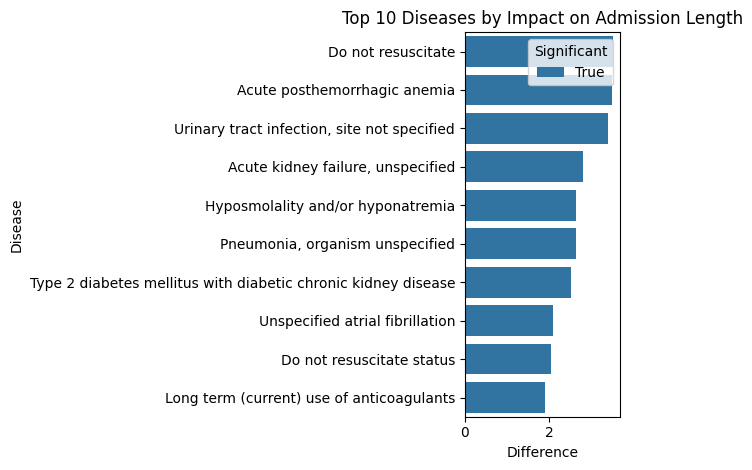

In [20]:
def analyze_disease_impact_on_admission(df, disease_cols):
    result = []
    for col in disease_cols:
        grp = df.groupby(col)['lengths_of_1st_admission']
        if grp.count().min() >= 10:
            with_d = grp.get_group(1)
            without_d = grp.get_group(0)
            diff = with_d.mean() - without_d.mean()
            p_val = ttest_ind(with_d, without_d, equal_var=False).pvalue
            result.append((col, diff, p_val))
    result_df = pd.DataFrame(result, columns=['Disease', 'Difference', 'P-value'])
    result_df['Significant'] = result_df['P-value'] < 0.05
    result_df.sort_values('Difference', key=abs, ascending=False, inplace=True)

    # Display top 10 diseases by impact
    display_cols = ['Disease', 'Difference', 'P-value', 'Significant']
    print("Top 10 diseases impacting admission length:")
    print(result_df[display_cols].head(10).to_string(index=False))

    sns.barplot(data=result_df.head(10), x='Difference', y='Disease', hue='Significant')
    plt.title('Top 10 Diseases by Impact on Admission Length')
    plt.tight_layout()
    plt.show()

analyze_disease_impact_on_admission(data, disease_columns)

## 9. Numerical vs Sum Correlation

In [21]:
def analyze_sum_correlations(df, numerical_cols, sum_cols):
    corr_df = df[numerical_cols + sum_cols].corr().loc[numerical_cols, sum_cols]
    fig = px.imshow(corr_df, title="Correlation Heatmap: Numerical vs Sum Columns")
    fig.show()

    # Flatten correlation values and display top 10
    flat_corrs = []
    for row in corr_df.index:
        for col in corr_df.columns:
            flat_corrs.append((row, col, corr_df.loc[row, col]))

    sorted_corrs = sorted(flat_corrs, key=lambda x: abs(x[2]), reverse=True)
    print("Top 10 Correlations:")
    for var1, var2, corr in sorted_corrs[:10]:
        print(f"{var1:<30} vs {var2:<30}: {corr:.3f}")

numerical_columns_1 = ['anchor_age', 'lengths_of_1st_admission', 'lengths_of_2nd_admission']
analyze_sum_correlations(data, numerical_columns_1, sum_columns)

Top 10 Correlations:
anchor_age                     vs ibuprofen Sum                 : -0.411
lengths_of_1st_admission       vs sodium chloride 0.9%  flush Sum: 0.400
anchor_age                     vs pneumococcal vac polyvalent Sum: 0.366
anchor_age                     vs pneumococcal 23-valent polysaccharide vaccine Sum: 0.310
anchor_age                     vs aspirin Sum                   : 0.289
lengths_of_1st_admission       vs lidocaine 1% (for picc/midline insertions) Sum: 0.288
lengths_of_1st_admission       vs sterile water Sum             : 0.284
lengths_of_1st_admission       vs furosemide Sum                : 0.264
lengths_of_1st_admission       vs soln Sum                      : 0.261
lengths_of_1st_admission       vs ondansetron Sum               : 0.261


## 10. Disease Co-Occurrence Correlation

In [23]:

def analyze_disease_cooccurrence(df, disease_cols, top_n=10):

    corr_matrix = df[disease_cols].corr()

    # Display heatmap
    import plotly.express as px
    fig = px.imshow(corr_matrix,
                    title="Disease Co-occurrence Correlation Heatmap",
                    labels=dict(color="Correlation"),
                    x=disease_cols,
                    y=disease_cols,
                    color_continuous_scale="Viridis",
                    zmin=-1, zmax=1)
    fig.update_layout(width=800, height=800)
    fig.show()

    # Flatten and show top correlated disease pairs (excluding self-correlation)
    corr_pairs = []
    for i in range(len(disease_cols)):
        for j in range(i+1, len(disease_cols)):
            d1 = disease_cols[i]
            d2 = disease_cols[j]
            corr = corr_matrix.loc[d1, d2]
            corr_pairs.append((d1, d2, corr))

    top_pairs = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:top_n]

    print("Top correlated disease pairs:")
    for d1, d2, corr in top_pairs:
        print(f"{d1:<30} <--> {d2:<30}: Correlation = {corr:.2f}")


In [24]:
import pandas as pd
import plotly.express as px

def analyze_disease_cooccurrence(df, disease_cols, top_n=10):

    # Calculate correlation matrix
    corr_matrix = df[disease_cols].corr()

    # Dynamic figure size based on number of diseases
    n_diseases = len(disease_cols)
    base_size = 800  # Minimum size
    size_factor = 20 #max(5, min(50, n_diseases))  # Scale between 20-50 pixels per disease
    fig_width = max(base_size, n_diseases * size_factor)
    fig_height = max(base_size, n_diseases * size_factor)

    # Optional: Truncate long labels (uncomment if needed)
    # short_labels = [col[:15] + '...' if len(col) > 15 else col for col in disease_cols]

    # Display heatmap
    fig = px.imshow(corr_matrix,
                    title="Disease Co-occurrence Correlation Heatmap",
                    labels=dict(color="Correlation"),
                    x=disease_cols,  # Use short_labels here if truncating
                    y=disease_cols,  # Use short_labels here if truncating
                    color_continuous_scale="Viridis",
                    zmin=-1, zmax=1)
    
    # Update layout for better readability
    fig.update_layout(
        width=fig_width,
        height=fig_height,
        xaxis=dict(
            tickangle=45,          # Rotate x-axis labels
            tickfont=dict(size=12) # Adjust font size
        ),
        yaxis=dict(
            tickfont=dict(size=12) # Adjust font size
        ),
        margin=dict(l=30, r=30, t=30, b=30),  # Increase margins
        title_x=0.5  # Center the title
    )
    
    fig.show()

    # Flatten and show top correlated disease pairs (excluding self-correlation)
    corr_pairs = []
    for i in range(len(disease_cols)):
        for j in range(i+1, len(disease_cols)):
            d1 = disease_cols[i]
            d2 = disease_cols[j]
            corr = corr_matrix.loc[d1, d2]
            corr_pairs.append((d1, d2, corr))

    top_pairs = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:top_n]

    print("Top correlated disease pairs:")
    for d1, d2, corr in top_pairs:
        print(f"{d1:<30} <--> {d2:<30}: Correlation = {corr:.2f}")


In [25]:
analyze_disease_cooccurrence(data, disease_columns)

Top correlated disease pairs:
Chronic kidney disease, unspecified <--> Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified: Correlation = 0.76
Aortocoronary bypass status    <--> Coronary atherosclerosis of unspecified type of vessel, native or graft: Correlation = 0.71
Coronary atherosclerosis of native coronary artery <--> Percutaneous transluminal coronary angioplasty status: Correlation = 0.53
Essential (primary) hypertension <--> Hyperlipidemia, unspecified   : Correlation = 0.49
Atrial fibrillation            <--> Long-term (current) use of anticoagulants: Correlation = 0.48
Anxiety disorder, unspecified  <--> Major depressive disorder, single episode, unspecified: Correlation = 0.45
Coronary atherosclerosis of native coronary artery <--> Old myocardial infarction     : Correlation = 0.44
Other and unspecified hyperlipidemia <--> Unspecified essential hypertension: Correlation = 0.43
Old myocardial infarction     